<div align="center">

<a id="import"></a>
# <p style="background-color:blue; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:15px 50px; padding:10px">Tugas Besar 2 IF3170 - Intelegensi Buatan</p>


| NIM | Nama |
| --- | --- |
| 13521004 | Henry Anand Septian Radityo |
| 13521007 | Matthew Mahendra |
| 13521015 | Hidayatullah Wildan Ghaly |
| 13521024 | Ahmad Nadil |

</div>

## Import Libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Dataset Reading

In [45]:
train_df = pd.read_csv("./data/data_train.csv")
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [46]:
validation_df =pd.read_csv("./data/data_validation.csv")
validation_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
596,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
597,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
598,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [47]:
test_df = pd.read_csv("./data/test.csv")
test_df

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0,1076,1,2.2,0,3,1,53,0.1,114,...,6,127,1314,1003,16,9,10,1,0,0
1,1,1310,0,2.4,0,0,0,40,0.5,118,...,0,1499,1687,3348,9,2,13,0,0,1
2,2,1915,0,1.1,0,6,0,30,0.6,181,...,8,266,1754,3815,13,4,7,0,0,0
3,3,587,0,1.4,0,9,1,8,0.5,142,...,13,128,593,3182,9,7,10,1,0,0
4,4,1526,0,1.8,0,5,1,11,0.1,131,...,7,150,1606,706,18,7,18,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1841,0,0.9,0,0,1,13,0.6,112,...,3,1311,1679,1645,15,9,12,1,1,1
1996,1996,1064,1,1.8,1,0,0,12,0.3,147,...,5,105,717,1509,16,10,14,0,0,0
1997,1997,1448,0,1.4,1,0,0,22,0.2,142,...,5,345,652,3807,11,7,9,0,0,0
1998,1998,1085,0,2.4,0,3,1,38,0.7,116,...,8,121,905,885,18,4,8,1,0,0


## Define Numeric and Non Numeric Columns

In [48]:
remove_col = [
    'clock_speed',
    'm_dep',
    'n_cores',
    'pc',
    'sc_w',
    'talk_time'
]

In [49]:
non_numeric_columns = ["blue", "wifi", "touch_screen", "three_g", "four_g", "dual_sim"]
drop_col = non_numeric_columns.copy()
drop_col.append("price_range")
numeric_columns = train_df.drop(drop_col, axis=1).columns.tolist()

for el in remove_col:
    numeric_columns.remove(el)
    
numeric_columns

['battery_power',
 'fc',
 'int_memory',
 'mobile_wt',
 'px_height',
 'px_width',
 'ram',
 'sc_h']

## Data Preprocessing

### Removing Outliers

Remove outliers using IQR

In [50]:
class OutlierRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.lower_bounds = {}
        self.upper_bounds = {}
        
    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns

        for column in self.columns:
            q3 = X[column].quantile(q=0.75)
            q1 = X[column].quantile(q=0.25)
            IQR = q3 - q1
            lower_bound = q1 - 1.5 * IQR
            upper_bound = q3 + 1.5 * IQR
            
            self.lower_bounds[column] = lower_bound
            self.upper_bounds[column] = upper_bound
        
        return self
    
    def transform(self, X):
        for column in self.columns:
            X = X[(X[column] >= self.lower_bounds[column]) & (X[column] <= self.upper_bounds[column])]
        return X

### Invalid Data Filling

Invalid data will be replace by median

In [51]:
class InvalidReplacement(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.median = X['px_height'].median()
        self.columns = X.columns
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            if col != 'price_range':
                X_[col] = X_[col].replace(0, X_[col].median())
        return X_

### Feature Selection

Remove fc column because it correlates the highest with pc

In [52]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.drop(columns = self.column)
        return X_

### Scaling and Normalizing

Scale values of numeric columns minus `fc`

In [53]:
# log transform
def log_transform(data):
    return np.log1p(data)

# square root transform
def sqrt_transform(data):
    return data**(1/2)

### Screen Area

Calculating screen resolution from px_height * px_width

In [54]:
class PixelAreaCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_['px_area'] = X['px_height'] * X['px_width']
        return X_

### Numeric Transformer

Transformations for each columns

In [55]:
numericTransformation = ColumnTransformer(
    transformers = [
        ('scaling', StandardScaler(), ['sc_h']),
        ('normalizing', Normalizer(), ['px_height']),
        ('log_transform', FunctionTransformer(log_transform, validate=False), ['mobile_wt']),
        ('sqrt_transform', FunctionTransformer(sqrt_transform, validate=False), ['sc_h', 'mobile_wt']),
    ],
    remainder = 'passthrough'
)

## Pipeline

Pipeline for all preprocessing

In [56]:
pipeline = Pipeline([
    ('removing outliers', OutlierRemoval(columns=numeric_columns)),
    ('invalid data replacement', InvalidReplacement()),
    ('feature selection', DropColumn(non_numeric_columns + ['fc'] + remove_col))
])

full_pipeline = Pipeline([
    ('preprocessor', pipeline),
#     ('scaling', numericTransformation)
])

processed_data = full_pipeline.fit_transform(train_df)

numeric_columns.remove("fc")
processed_train = pd.DataFrame(processed_data, columns = numeric_columns + ['price_range'])
processed_train

,battery_power,int_memory,mobile_wt,px_height,px_width,ram,sc_h,price_range
0,804,41,89,709,818,2027,11,1
1,1042,11,139,68,1018,2826,18,2
2,1481,35,105,249,522,2635,17,2
3,1104,60,199,653,1413,1229,6,0
4,652,58,142,464,781,565,18,0
...,...,...,...,...,...,...,...,...
1395,536,53,135,547,705,1211,15,0
1396,1097,21,160,1277,1352,2219,15,2
1397,1179,32,182,85,1451,340,16,0
1398,719,23,113,431,1727,3990,14,3


In [57]:
processed_val = full_pipeline.fit_transform(validation_df)
processed_val = pd.DataFrame(processed_val, columns = numeric_columns + ['price_range'])

## Split Data

In [58]:
y_train = processed_train['price_range']
X_train = processed_train.drop(columns=['price_range'])

In [59]:
X_val = processed_val.drop(columns=['price_range'])
y_val = processed_val['price_range']

## KNN Model by MelihatA

In [60]:
import numpy as np
class KNN_Model():
    # Constructor
    # Define the number of neighbors to use in prediction
    # Default neighbors = 3
    def __init__(self, k=3, dist=1, weights="uniform"):
        self.k = k
        self.dist = dist
        self.weights = weights
    
    # Fit Method
    # Fit the training dataset to the model
    # X are the features, Y is the target
    def fit(self, X, y):
        self.features = X.columns
        self.X_train = X.to_numpy()
        self.y_train = y.to_numpy()
    
    # Predict Method
    # Prediction using KNN Algorithm
    # X is the data to be predicted
    # Return Predicted Data
    def __predict(self, X):
        if (self.dist == 1):
            distances = [self.__euclidean_distance(X, train) for train in self.X_train]
        else:
            # other distance e.g. : Manhattan
            distances = [self.__manhattan_distance(X, train) for train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = None
        if(self.weights == "uniform"):
            most_common = np.bincount(k_nearest_labels)
        elif(self.weights == "distance"):
            weights = 1 / (np.array(distances) + 1e-10)
            chosen_weights = [weights[i] for i in k_indices]
            most_common = np.bincount(k_nearest_labels, weights=chosen_weights)
        return np.argmax(most_common)

    
    def predict(self, X):
        X_ = X.to_numpy()
        result = [self.__predict(test) for test in X_]
        return np.array(result)
    
    # Distance Method for KNN
    def __euclidean_distance(self,p1,p2):
        p1_numeric = np.array(p1, dtype=float)
        p2_numeric = np.array(p2, dtype=float)
        return np.sqrt(np.sum((p1_numeric - p2_numeric) ** 2))
    
    def __manhattan_distance(self, p1, p2):
        p1_numeric = np.array(p1, dtype=float)
        p2_numeric = np.array(p2, dtype=float)
        return np.abs(p1_numeric - p2_numeric)

### KNN Modelling

In [61]:
knn = KNN_Model(k=11, weights="distance")
knn.fit(X_train, y_train)

### Prediction

In [62]:
y_pred_knn = knn.predict(X_val)

### Evaluation

In [63]:
acc = accuracy_score(y_val, y_pred_knn)
print(f"Accuracy Percentage: {np.round(acc * 100, 2)}")

f1 = f1_score(y_val, y_pred_knn, average='weighted')  
print(f"F1 Score: {np.round(f1, 2)}")

precision = precision_score(y_val, y_pred_knn, average='weighted')
print(f"Precision: {np.round(precision, 2)}")

recall = recall_score(y_val, y_pred_knn, average='weighted')
print(f"Recall: {np.round(recall, 2)}")

Accuracy Percentage: 92.64
F1 Score: 0.93
Precision: 0.93
Recall: 0.93


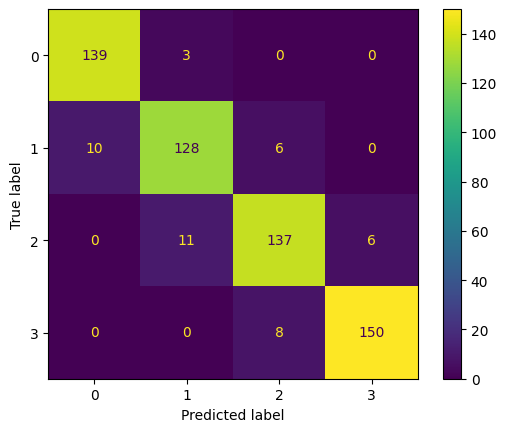

In [64]:
knn_cm = confusion_matrix(y_val, y_pred_knn)
disp = ConfusionMatrixDisplay(knn_cm)
disp.plot()
plt.show()

### Saving Model

In [65]:
joblib.dump(knn, "./out/knn.pkl")

['./out/knn.pkl']

## Scikit KNN

### KNN Modelling

In [66]:
scikit_knn = KNeighborsClassifier(n_neighbors = 11, weights="distance")
scikit_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11, weights='distance')

### Prediction

In [67]:
y_pred = scikit_knn.predict(X_val)
y_pred

array([1, 2, 3, 0, 2, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 2,
       0, 1, 2, 0, 3, 1, 0, 3, 1, 3, 3, 0, 2, 3, 1, 3, 2, 1, 0, 2, 0, 2,
       2, 1, 1, 2, 2, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 2,
       3, 2, 3, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 2, 1, 3, 2, 0, 3, 2, 3, 1, 2, 3, 2, 3, 3, 3, 3,
       2, 3, 2, 1, 3, 1, 0, 2, 1, 3, 1, 2, 3, 3, 2, 0, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 2, 3, 0, 1, 3, 3, 1, 2, 3, 1, 2, 1, 2, 3, 0, 0, 2,
       1, 1, 2, 0, 1, 3, 3, 3, 0, 2, 3, 0, 0, 1, 0, 2, 2, 1, 0, 1, 0, 1,
       3, 1, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 3, 2, 1, 0, 2, 0, 1, 3,
       3, 1, 1, 2, 2, 3, 2, 3, 3, 3, 0, 2, 1, 2, 3, 1, 2, 2, 3, 0, 0, 2,
       2, 1, 3, 3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 2, 3, 0, 2, 3, 3, 3, 0, 0,
       1, 1, 3, 3, 1, 1, 0, 2, 2, 1, 3, 3, 0, 2, 2, 0, 0, 1, 0, 2, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 1, 3, 2, 2, 2, 0, 1, 0, 2, 1, 1,
       0, 1, 3, 1, 3, 0, 1, 0, 1, 3, 3, 2, 0, 3, 1,

### Evaluation

In [68]:
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy Percentage: {np.round(acc * 100, 2)}")

f1 = f1_score(y_val, y_pred, average='weighted')  
print(f"F1 Score: {np.round(f1, 2)}")

precision = precision_score(y_val, y_pred, average='weighted')
print(f"Precision: {np.round(precision, 2)}")

recall = recall_score(y_val, y_pred, average='weighted')
print(f"Recall: {np.round(recall, 2)}")

Accuracy Percentage: 92.64
F1 Score: 0.93
Precision: 0.93
Recall: 0.93


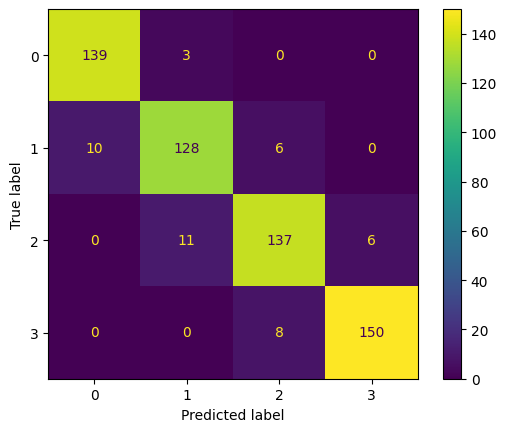

In [69]:
knn_cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(knn_cm)
disp.plot()
plt.show()

### Save Model

In [70]:
joblib.dump(scikit_knn, "./out/scikit_knn.pkl")

['./out/scikit_knn.pkl']

## Naive Bayes by MelihatA

### Naive Bayes Modelling

In [71]:
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            

    def predict(self, X):
        y_pred = [self._predict(test) for test in np.array(X)]
        return np.array(y_pred)

    def _predict(self, test):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, test)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var + 1e-10))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [72]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

### Prediction

In [73]:
y_pred_nb = nb.predict(X_val)
y_pred_nb

array([2, 2, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 1,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 3, 3, 1, 2, 3, 2, 3, 1, 1, 0, 3, 0, 2,
       2, 1, 1, 2, 1, 3, 2, 2, 3, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 3, 2, 3, 3,
       2, 3, 2, 2, 3, 2, 0, 3, 1, 3, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 1, 3, 0, 1, 3, 3, 1, 2, 2, 1, 2, 1, 2, 3, 1, 0, 2,
       1, 0, 3, 0, 0, 3, 3, 3, 0, 2, 3, 0, 0, 1, 0, 2, 3, 1, 0, 1, 1, 1,
       3, 0, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 3, 2, 0, 1, 2, 0, 1, 3,
       3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 0, 2, 0, 2, 3, 1, 2, 3, 2, 0, 0, 2,
       2, 2, 2, 3, 0, 2, 0, 3, 0, 2, 1, 2, 2, 1, 3, 0, 1, 3, 3, 3, 0, 0,
       1, 1, 3, 3, 2, 2, 0, 2, 1, 2, 3, 3, 0, 2, 1, 1, 1, 2, 0, 2, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 2, 2, 2, 0, 1, 0, 2, 1, 1,
       0, 0, 3, 0, 3, 0, 1, 0, 1, 3, 2, 2, 0, 2, 1,

### Evaluation

In [74]:
acc = accuracy_score(y_val, y_pred_nb)
print(f"Accuracy Percentage: {np.round(acc * 100, 2)}")

f1 = f1_score(y_val, y_pred_nb, average='weighted')  
print(f"F1 Score: {np.round(f1, 2)}")

precision = precision_score(y_val, y_pred_nb, average='weighted')
print(f"Precision: {np.round(precision, 2)}")

recall = recall_score(y_val, y_pred_nb, average='weighted')
print(f"Recall: {np.round(recall, 2)}")

Accuracy Percentage: 79.26
F1 Score: 0.79
Precision: 0.79
Recall: 0.79


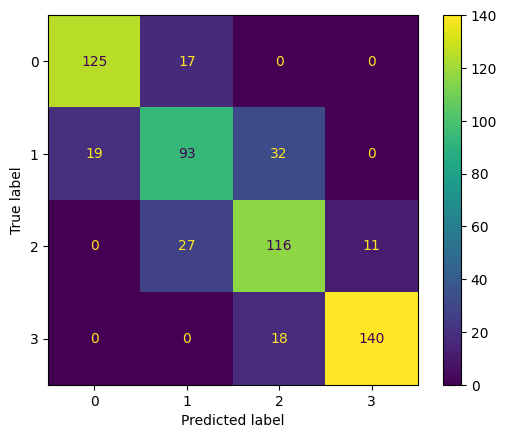

In [75]:
nb_cm = confusion_matrix(y_val, y_pred_nb)
disp = ConfusionMatrixDisplay(nb_cm)
disp.plot()
plt.show()

### Save Model

In [76]:
joblib.dump(nb, "./out/naive_bayes.pkl")

['./out/naive_bayes.pkl']

## Scikit Naive Bayes

### Model

In [77]:
scikit_nb = GaussianNB()
scikit_nb.fit(X_train, y_train)

GaussianNB()

### Prediction

In [78]:
y_pred_nb_scikit = scikit_nb.predict(X_val)
y_pred_nb_scikit

array([2, 2, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 1,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 3, 3, 1, 2, 3, 2, 3, 1, 1, 0, 3, 0, 2,
       2, 1, 1, 2, 1, 3, 2, 2, 3, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 3, 2, 3, 3,
       2, 3, 2, 2, 3, 2, 0, 3, 1, 3, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 1, 3, 0, 1, 3, 3, 1, 2, 2, 1, 2, 1, 2, 3, 1, 0, 2,
       1, 0, 3, 0, 0, 3, 3, 3, 0, 2, 3, 0, 0, 1, 0, 2, 3, 1, 0, 1, 1, 1,
       3, 0, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 3, 2, 0, 1, 2, 0, 1, 3,
       3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 0, 2, 0, 2, 3, 1, 2, 3, 2, 0, 0, 2,
       2, 2, 2, 3, 0, 2, 0, 3, 0, 2, 1, 2, 2, 1, 3, 0, 1, 3, 3, 3, 0, 0,
       1, 1, 3, 3, 2, 2, 0, 2, 1, 2, 3, 3, 0, 2, 1, 1, 1, 2, 0, 2, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 2, 2, 2, 0, 1, 0, 2, 1, 1,
       0, 0, 3, 0, 3, 0, 1, 0, 1, 3, 2, 2, 0, 2, 1,

### Evaluation

In [79]:
acc = accuracy_score(y_val, y_pred_nb_scikit)
print(f"Accuracy Percentage: {np.round(acc * 100, 2)}")

f1 = f1_score(y_val, y_pred_nb_scikit, average='weighted')  
print(f"F1 Score: {np.round(f1, 2)}")

precision = precision_score(y_val, y_pred_nb_scikit, average='weighted')
print(f"Precision: {np.round(precision, 2)}")

recall = recall_score(y_val, y_pred_nb_scikit, average='weighted')
print(f"Recall: {np.round(recall, 2)}")

Accuracy Percentage: 79.26
F1 Score: 0.79
Precision: 0.79
Recall: 0.79


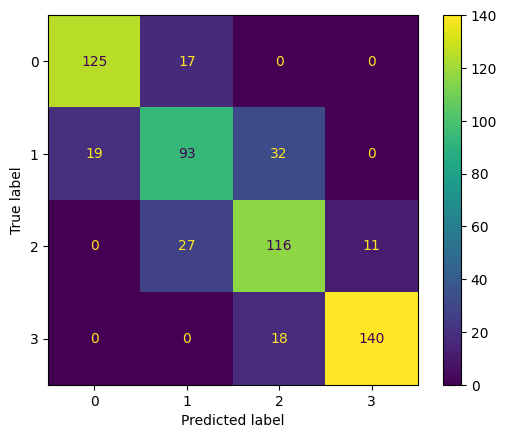

In [80]:
nb_cm = confusion_matrix(y_val, y_pred_nb_scikit)
disp = ConfusionMatrixDisplay(nb_cm)
disp.plot()
plt.show()

### Saving Model


In [81]:
joblib.dump(scikit_nb, "./out/scikit_naive_bayes.pkl")

['./out/scikit_naive_bayes.pkl']

## Submission

In [82]:
pipeline = Pipeline([
    ('invalid data replacement', InvalidReplacement()),
    ('feature selection', DropColumn(non_numeric_columns + ['fc'] + remove_col))
])

full_pipeline = Pipeline([
    ('preprocessor', pipeline)
])

In [83]:
id_test = test_df['id']

In [84]:
prep_test_df = test_df.drop(columns=["id"])
prep_test_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1076,1,2.2,0,3,1,53,0.1,114,6,6,127,1314,1003,16,9,10,1,0,0
1,1310,0,2.4,0,0,0,40,0.5,118,5,0,1499,1687,3348,9,2,13,0,0,1
2,1915,0,1.1,0,6,0,30,0.6,181,3,8,266,1754,3815,13,4,7,0,0,0
3,587,0,1.4,0,9,1,8,0.5,142,7,13,128,593,3182,9,7,10,1,0,0
4,1526,0,1.8,0,5,1,11,0.1,131,1,7,150,1606,706,18,7,18,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1841,0,0.9,0,0,1,13,0.6,112,5,3,1311,1679,1645,15,9,12,1,1,1
1996,1064,1,1.8,1,0,0,12,0.3,147,2,5,105,717,1509,16,10,14,0,0,0
1997,1448,0,1.4,1,0,0,22,0.2,142,6,5,345,652,3807,11,7,9,0,0,0
1998,1085,0,2.4,0,3,1,38,0.7,116,6,8,121,905,885,18,4,8,1,0,0


In [85]:
test_tf = full_pipeline.fit_transform(prep_test_df)
test_tf_df = pd.DataFrame(test_tf, columns = numeric_columns)
# X_test = test_tf_df.drop(columns=['price_range'])
X_test = test_tf_df.copy()

In [86]:
y_submit = knn.predict(X_test)
y_submit

array([0, 3, 3, ..., 3, 0, 3], dtype=int64)

In [87]:
y_submit_df =  pd.DataFrame(y_submit, columns=["price_range"])
submit = pd.concat([id_test, y_submit_df], axis = 1)
submit

,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


In [88]:
y_submit_df['price_range'] = y_submit_df['price_range'].astype(int)
submit = pd.concat([id_test, y_submit_df], axis=1)

In [89]:
submit['price_range'].value_counts()

price_range
2    506
0    505
1    499
3    490
Name: count, dtype: int64

In [90]:
submit.to_csv('./submissions/submission.csv', index=False)